In [1]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam 
from kerastuner import RandomSearch
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('/kaggle/input/brain-tumor-classification-mri/Training/')
path_test = ('/kaggle/input/brain-tumor-classification-mri/Testing/')
img_size = 300

for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)
        
for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)
        

train_img = (np.array(train_img))
test_img = (np.array(test_img))


train_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(test_labels)]

In [3]:
print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 300, 300, 3)  and shape of test:  (394, 300, 300, 3)


In [4]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

In [5]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

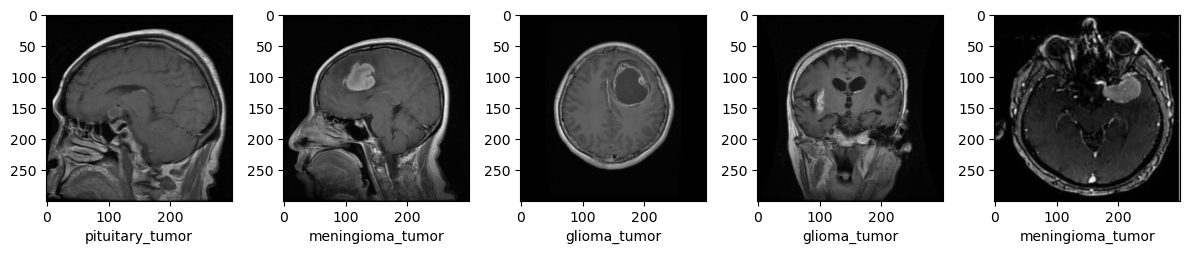

In [6]:
import random 

plt.figure(figsize = (12, 12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    rand = random.randint(0, len(train_img))
    plt.imshow(train_img[rand])
    plt.xlabel(train_labels[rand])
    plt.tight_layout()

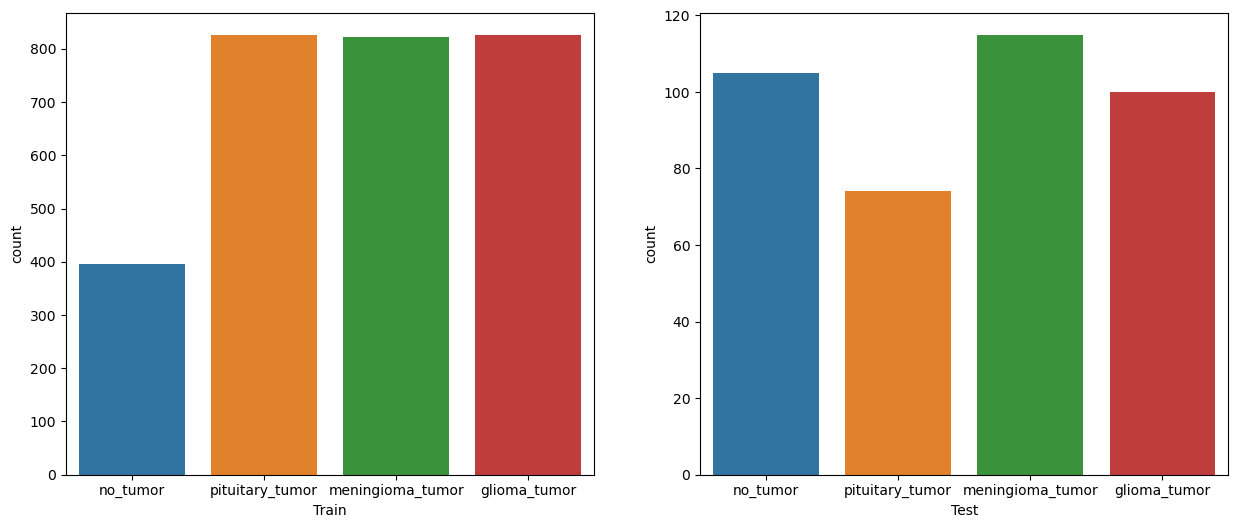

In [7]:
plt.figure(figsize = (15, 6))
lis = ['Train', 'Test']
for i, j in enumerate([train_labels, test_labels]):
    plt.subplot(1, 2, i+1)
    sns.countplot(x = j)
    plt.xlabel(lis[i])

## Building The Model With Pytorch

In [8]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

In [9]:
transforming_img = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

In [10]:
train_path = ('/kaggle/input/brain-tumor-classification-mri/Training/')
test_path = ('/kaggle/input/brain-tumor-classification-mri/Testing/')

train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transforming_img),
    batch_size=64, shuffle=True
)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transforming_img),
    batch_size=32, shuffle=True
)


#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [11]:
print(f'The classes are: {classes}')

The classes are: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_count = len(glob.glob(train_path+'/**/*.jpg'))
test_count = len(glob.glob(test_path+'/**/*.jpg'))

cuda


In [13]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1) # output height = 150 
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2) # output height = 75
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1) # output height = 75
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1) # output height = 75
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*75*75)
        output=self.fc(output)
            
        return output
    
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   
model=ConvNet(num_classes=4).to(device)

MaxPool2d : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [14]:
for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

In [15]:
images.shape

torch.Size([54, 3, 150, 150])

In [17]:
#Optmizer and loss function
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

best_accuracy = 0.0

for epoch in range(20):
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*images.size(0)
        _, prediction = torch.max(outputs.data, dim=1)
        
        train_accuracy += int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy    
        
        
    

Epoch: 0 Train Loss: tensor(11.5932) Train Accuracy: 0.5536585365853659 Test Accuracy: 0.3477157360406091
Epoch: 1 Train Loss: tensor(3.0267) Train Accuracy: 0.7289198606271777 Test Accuracy: 0.49746192893401014
Epoch: 2 Train Loss: tensor(1.3699) Train Accuracy: 0.8045296167247387 Test Accuracy: 0.5989847715736041
Epoch: 3 Train Loss: tensor(0.6807) Train Accuracy: 0.8735191637630662 Test Accuracy: 0.5964467005076142
Epoch: 4 Train Loss: tensor(0.5006) Train Accuracy: 0.9020905923344947 Test Accuracy: 0.7081218274111675
Epoch: 5 Train Loss: tensor(0.3011) Train Accuracy: 0.932404181184669 Test Accuracy: 0.6751269035532995
Epoch: 6 Train Loss: tensor(0.2990) Train Accuracy: 0.9233449477351916 Test Accuracy: 0.6675126903553299
Epoch: 7 Train Loss: tensor(0.5134) Train Accuracy: 0.90801393728223 Test Accuracy: 0.6979695431472082
Epoch: 8 Train Loss: tensor(0.2512) Train Accuracy: 0.9515679442508711 Test Accuracy: 0.7081218274111675
Epoch: 9 Train Loss: tensor(0.1166) Train Accuracy: 0.96

# Reference 
https://www.kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch